# Estimize: Analyst-by-Analyst Estimates

In this notebook, we'll take a look at Estimizes's *Analyst-by-Analyst Estimates* dataset, available on the [Quantopian](https://www.quantopian.com/store). This dataset spans January, 2010 through the current day.

This data contains a record for every estimate made by an individual on the Estimize product. By comparison, the Estimize Revisions product provides rolled-up consensus numbers for each possible earnings announcement.

In this notebook, we'll examine these detailed estimates and pull in that consensus data as well.

### Blaze
Before we dig into the data, we want to tell you about how  you generally access Quantopian Store data sets. These datasets are available using the [Blaze](http://blaze.pydata.org) library. Blaze provides the Quantopian user with a convenient interface to access very large datasets.

Blaze provides an important function for accessing these datasets. Some of these sets are many millions of records. Bringing that data directly into Quantopian Research directly just is not viable. So Blaze allows us to provide a simple querying interface and shift the burden over to the server side.

To learn more about using Blaze and generally accessing Quantopian Store data, clone [this tutorial notebook](https://www.quantopian.com/clone_notebook?id=561827d21777f45c97000054).

### Free samples and limits
A few key caveats:

1) We limit the number of results returned from any given expression to 10,000 to protect against runaway memory usage. To be clear, you have access to all the data server side. We are limiting the size of the responses back from Blaze.

2) There is a *free* version of this dataset as well as a paid one. The free one includes about three years of historical data, though not up to the current day.

With preamble in place, let's get started:

In [1]:
# import the free sample of the dataset
from quantopian.interactive.data.estimize import estimates_free

# or if you want to import the full dataset, use:
# from quantopian.interactive.data.estimize import estimates

# import data operations
from odo import odo
# import other libraries we will use
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Let's use blaze to understand the data a bit using Blaze dshape()
estimates_free.dshape

dshape("""var * {
  analyst_id: ?string,
  asof_date: datetime,
  eps: ?float64,
  fiscal_quarter: ?float64,
  fiscal_year: ?float64,
  id: ?string,
  revenue: ?float64,
  symbol: ?string,
  username: ?string,
  timestamp: datetime,
  sid: ?int64
  }""")

In [3]:
# And how many rows are in this free sample?
# N.B. we're using a Blaze function to do this, not len()
estimates_free.count()

120400

In [4]:
# Let's see what the data looks like. We'll grab the first three rows.
estimates_free.head(3)

,analyst_id,asof_date,eps,fiscal_quarter,fiscal_year,id,revenue,symbol,username,timestamp,sid
0,4e679bb77cb02d0b6700000f,2010-01-02 17:00:00,0.90,1,2011,4e6dee5a7cb02d2adc000014,26430,AAPL,postsateventide,2010-01-02 17:20:00,24
1,4e679bb77cb02d0b67000005,2010-09-28 16:00:00,0.63,4,2010,4e6df18f7cb02d2adc000024,19530,AAPL,DennisHildebrand,2010-09-28 16:20:00,24
2,4e679bb87cb02d0b6700001b,2010-09-28 16:00:00,0.71,4,2010,4e6df0977cb02d2adc00001f,20500,AAPL,asymco,2010-09-28 16:20:00,24


Let's go over the columns:
- **analyst_id**: the unique identifier assigned by Estimize for the person making the estimate.
- **asof_date**: Estimize's timestamp of event capture.
- **eps**: EPS estimate made by the analyst on the `asof_date`
- **fiscal_quarter**: fiscal quarter for which this estimate is made, related to `fiscal_year`
- **fiscal_year**: fiscal year for which this estimate is made, related to `fiscal_quarter`
- **revenue**: revenue estimate made by the analyst on the `asof_date`
- **symbol**: ticker symbol provided by Estimize for the company for whom these estimates have been made
- **username**: Estimize username of the analyst making this estimate
- **timestamp**: the datetime when Quantopian registered the data. For data loaded up via initial, historic loads, this timestamp is an estimate.
- **sid**: the equity's unique identifier. Use this instead of the symbol. Derived by Quantopian using the symbol and our market data

We've done much of the data processing for you. Fields like `asof_date` and `sid` are standardized across all our Store Datasets, so the datasets are easy to combine. We have standardized the `sid` across all our equity databases.

We can select columns and rows with ease. Below, let's just look at the estimates made for TSLA for a particular quarter. Also, we're filtering out some spurious data:

In [5]:
stocks = symbols('TSLA')
one_quarter = estimates_free[(estimates_free.sid == stocks.sid) &
                 (estimates_free.fiscal_year == '2014') &
                 (estimates_free.fiscal_quarter == '1') &
                 (estimates_free.eps < 100)
                ]
one_quarter.head(5)

,analyst_id,asof_date,eps,fiscal_quarter,fiscal_year,id,revenue,symbol,username,timestamp,sid
0,500ee59d810f8d1c49000091,2013-05-30 19:00:13,0.08,1,2014,51a7a1bd810f8d6e27000362,500,TSLA,hsctiger2009,2013-05-30 19:20:13,39840
1,4f997632810f8d1aaf0001ec,2013-09-18 14:11:45,0.35,1,2014,5239b4a1b7529b033a001ecc,700,TSLA,aarkayne,2013-09-18 14:31:45,39840
2,500ee59d810f8d1c49000091,2013-09-20 21:56:58,0.33,1,2014,523cc4aab7529b009b00b0e1,620,TSLA,hsctiger2009,2013-09-20 22:16:58,39840
3,500ee59d810f8d1c49000091,2013-09-26 16:40:26,0.35,1,2014,5244637ab7529bb85c033499,620,TSLA,hsctiger2009,2013-09-26 17:00:26,39840
4,524990dfb7529b150a01af9a,2013-09-30 15:49:41,0.30,1,2014,52499d95b7529b6c8201d1ef,590,TSLA,wjhughes,2013-09-30 16:09:41,39840


How many records do we have now?

In [6]:
one_quarter.count()

136

Let's break it down by user:

In [7]:
one_quarter.username.count_values()

,username,count
0,Analyst_7066456,3
1,Cwill,3
2,hsctiger2009,3
3,a76marine,3
4,wjbuckner,3
5,phi16,3
6,Mgspooner,3
7,Essential,2
8,Nils1975,2
9,Cassanova23,2


Let's convert it over to a Pandas DataFrame so we can chart it and examine it closer

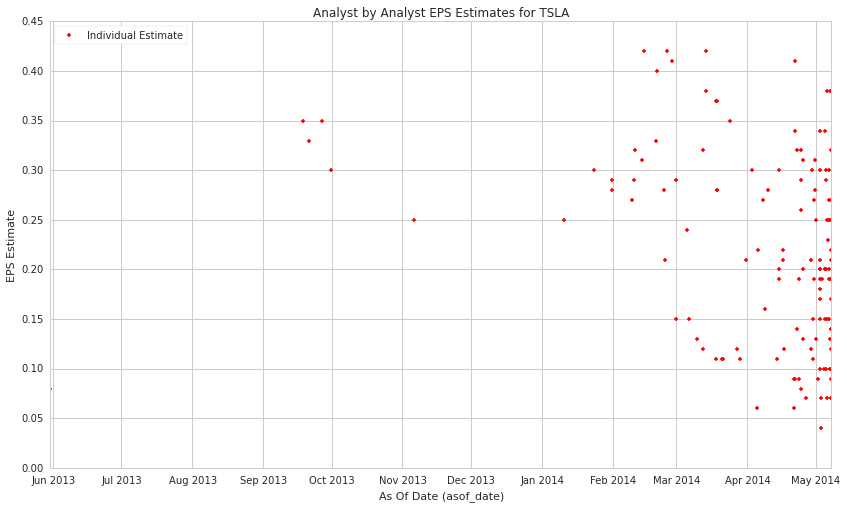

In [31]:
one_q_df = odo(one_quarter.sort('asof_date'), pd.DataFrame)
plt.plot(one_q_df.asof_date, one_q_df.eps, marker='.', linestyle='None', color='r')
plt.xlabel("As Of Date (asof_date)")
plt.ylabel("EPS Estimate")
plt.title("Analyst by Analyst EPS Estimates for TSLA")
plt.legend(["Individual Estimate"], loc=2)

That's neat. But let's add in some data from another dataset -- the Estimize Revisions data. For the same timeframe, the revisions data provides each revision to the overall consensus estimates. So where `estimates_free` data provides every single estimate made by an individual on the Estimize site, `revisions_free` provides rolled up summaries of the estimates.

In [32]:
from quantopian.interactive.data.estimize import revisions_free
consensus = revisions_free[(revisions_free.sid == stocks.sid) &
                 (revisions_free.fiscal_year == '2014') &
                 (revisions_free.fiscal_quarter == '1') &
                 (revisions_free.source == 'estimize') &
                 (revisions_free.metric == 'eps')
                ]

In [33]:
consensus.head(3)

,count,high,low,mean,metric,source,standard_deviation,asof_date,consensus_eps_estimate,consensus_revenue_estimate,eps,fiscal_quarter,fiscal_year,id,name,release_date,revenue,symbol,wallstreet_eps_estimate,wallstreet_revenue_estimate,timestamp,sid
0,112,0.42,0.04,0.210357,eps,estimize,0.095823,2014-05-07 19:22:15.904000,0.210714285714286,719.256071428571,0.12,1,2014,510c4310810f8d63ab004f49,"Tesla Motors, Inc.",2014-05-07 20:00:00,713.0,TSLA,0.08,693.425,2014-05-07 19:42:15.904000,39840
1,111,0.42,0.04,0.211622,eps,estimize,0.095319,2014-05-07 19:08:04.281000,0.210714285714286,719.256071428571,0.12,1,2014,510c4310810f8d63ab004f49,"Tesla Motors, Inc.",2014-05-07 20:00:00,713.0,TSLA,0.08,693.425,2014-05-07 19:28:04.281000,39840
2,110,0.42,0.04,0.212727,eps,estimize,0.095040,2014-05-07 18:38:08.005000,0.210714285714286,719.256071428571,0.12,1,2014,510c4310810f8d63ab004f49,"Tesla Motors, Inc.",2014-05-07 20:00:00,713.0,TSLA,0.08,693.425,2014-05-07 18:58:08.005000,39840


For this quick demonstration, let's just grab the consensus mean from the `revisions_free` data set and convert it over to Pandas. Note, we need to rename the `mean` column name because it causes problems otherwise:

In [13]:
consensus_df = odo(consensus[['asof_date', 'mean']].sort('asof_date'), pd.DataFrame)
consensus_df.rename(columns={'mean':'eps_mean'}, inplace=True)

Let's chart that in the same chart again so we get a trend of the mean over time, overlayed on a chart of each individual analyst estimate:

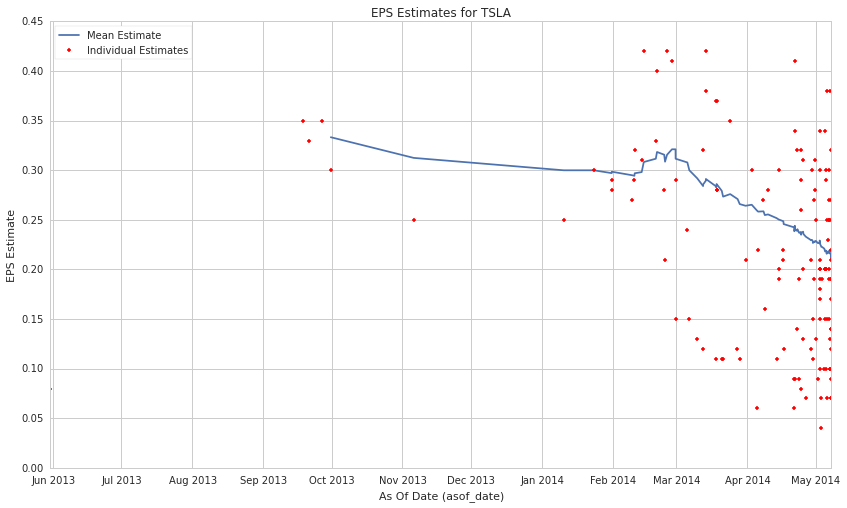

In [30]:
plt.plot(consensus_df.asof_date, consensus_df.eps_mean)
plt.plot(one_q_df.asof_date, one_q_df.eps, marker='.', linestyle='None', color='r')
plt.xlabel("As Of Date (asof_date)")
plt.ylabel("EPS Estimate")
plt.title("EPS Estimates for TSLA")
plt.legend(["Mean Estimate", "Individual Estimates"], loc=2)